In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

# balance data
from imblearn.over_sampling import BorderlineSMOTE

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from mlens.ensemble import SuperLearner
from sklearn.neural_network import MLPClassifier

# evaluations
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# to display the total number columns present in the dataset
pd.set_option('display.max_columns', None)
data = pd.read_csv('customer-churn-dataset.csv')
data.describe()

[MLENS] backend: threading


ModuleNotFoundError: No module named 'distutils'

In [ ]:
data = data.replace(r'^\s*$', np.nan, regex=True)
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

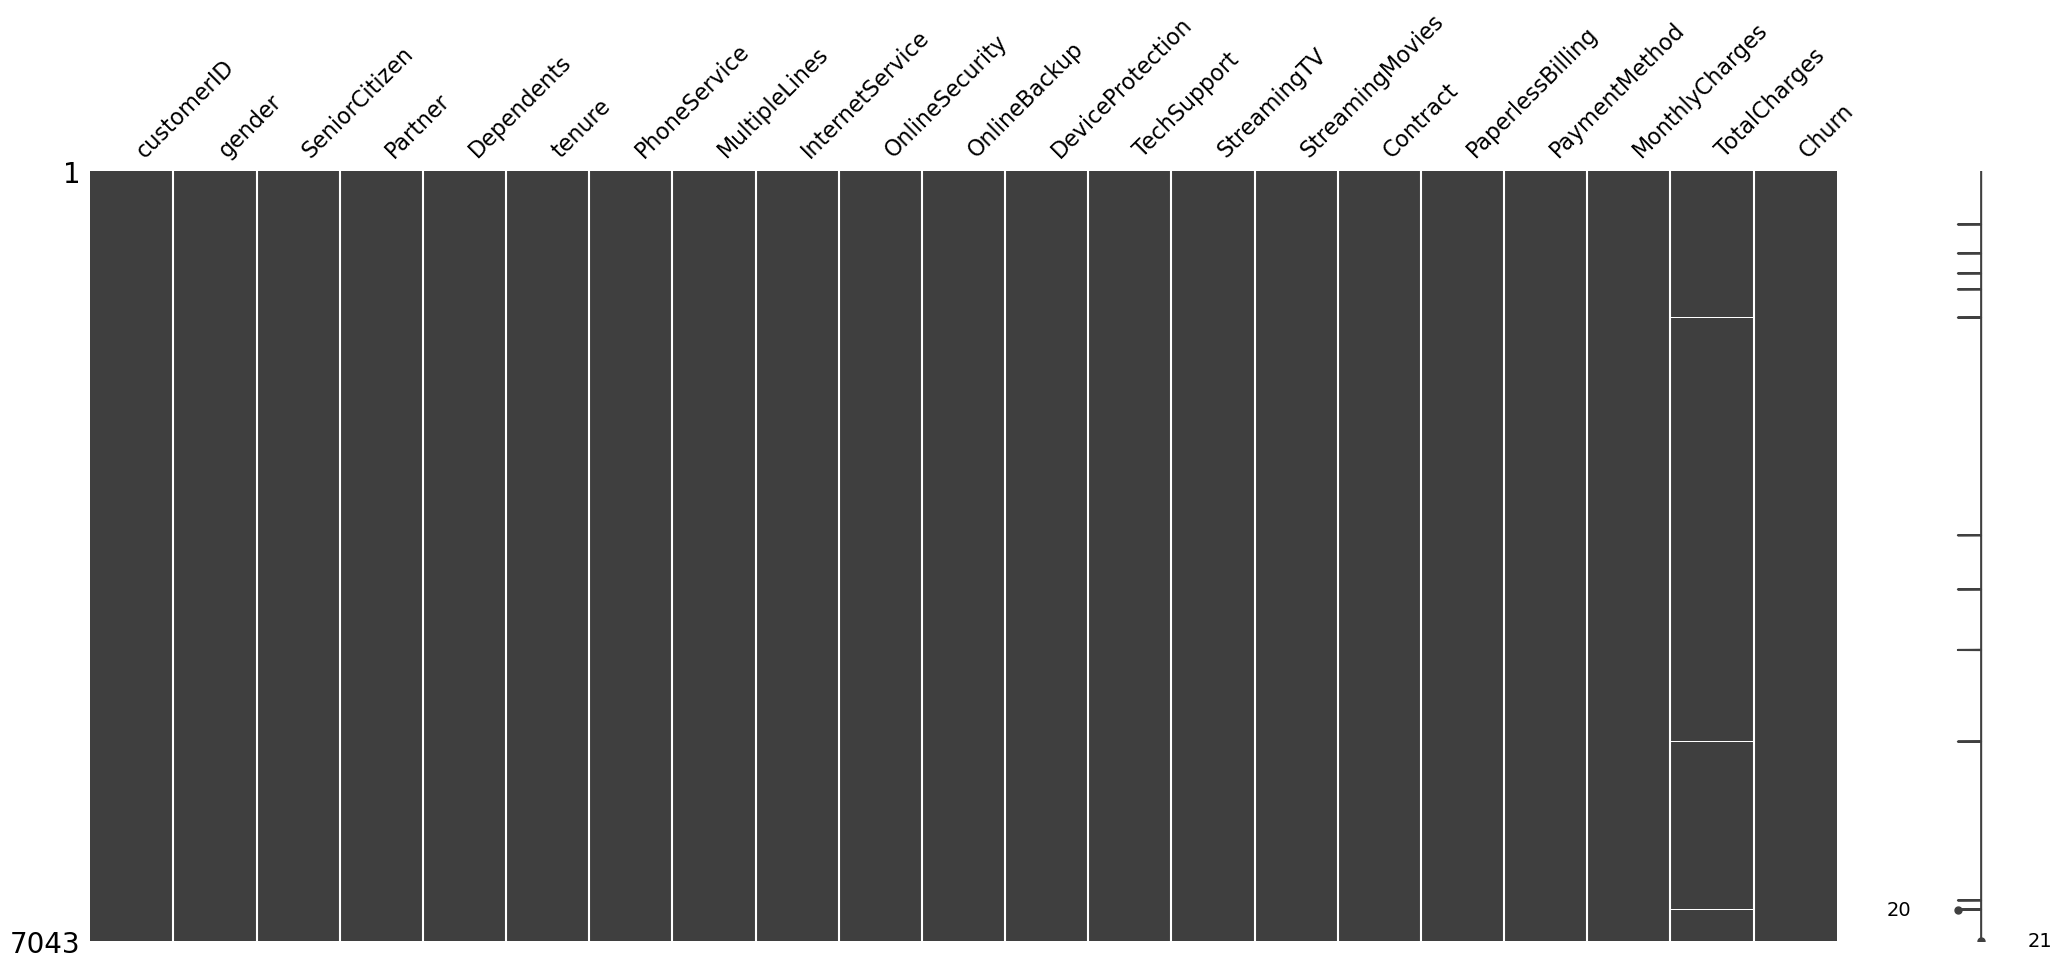

In [ ]:
msno.matrix(data);

In [ ]:
data[data['TotalCharges'].isnull()].index.tolist()

[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]

In [ ]:
ind = data[data['TotalCharges'].isnull()].index.tolist()
for i in ind:
  if data['Contract'].iloc[i,] == 'Two year':
    data['TotalCharges'].iloc[i,] = int(np.maximum(data['tenure'].iloc[i,], 1)) * data['MonthlyCharges'].iloc[i,] * 24
  elif data['Contract'].iloc[i,] == 'One year':
    data['TotalCharges'].iloc[i,] = int(np.maximum(data['tenure'].iloc[i,], 1)) * data['MonthlyCharges'].iloc[i,] * 12
  else:
    data['TotalCharges'].iloc[i,] = int(np.maximum(data['tenure'].iloc[i,], 1)) * data['MonthlyCharges'].iloc[i,]

In [ ]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

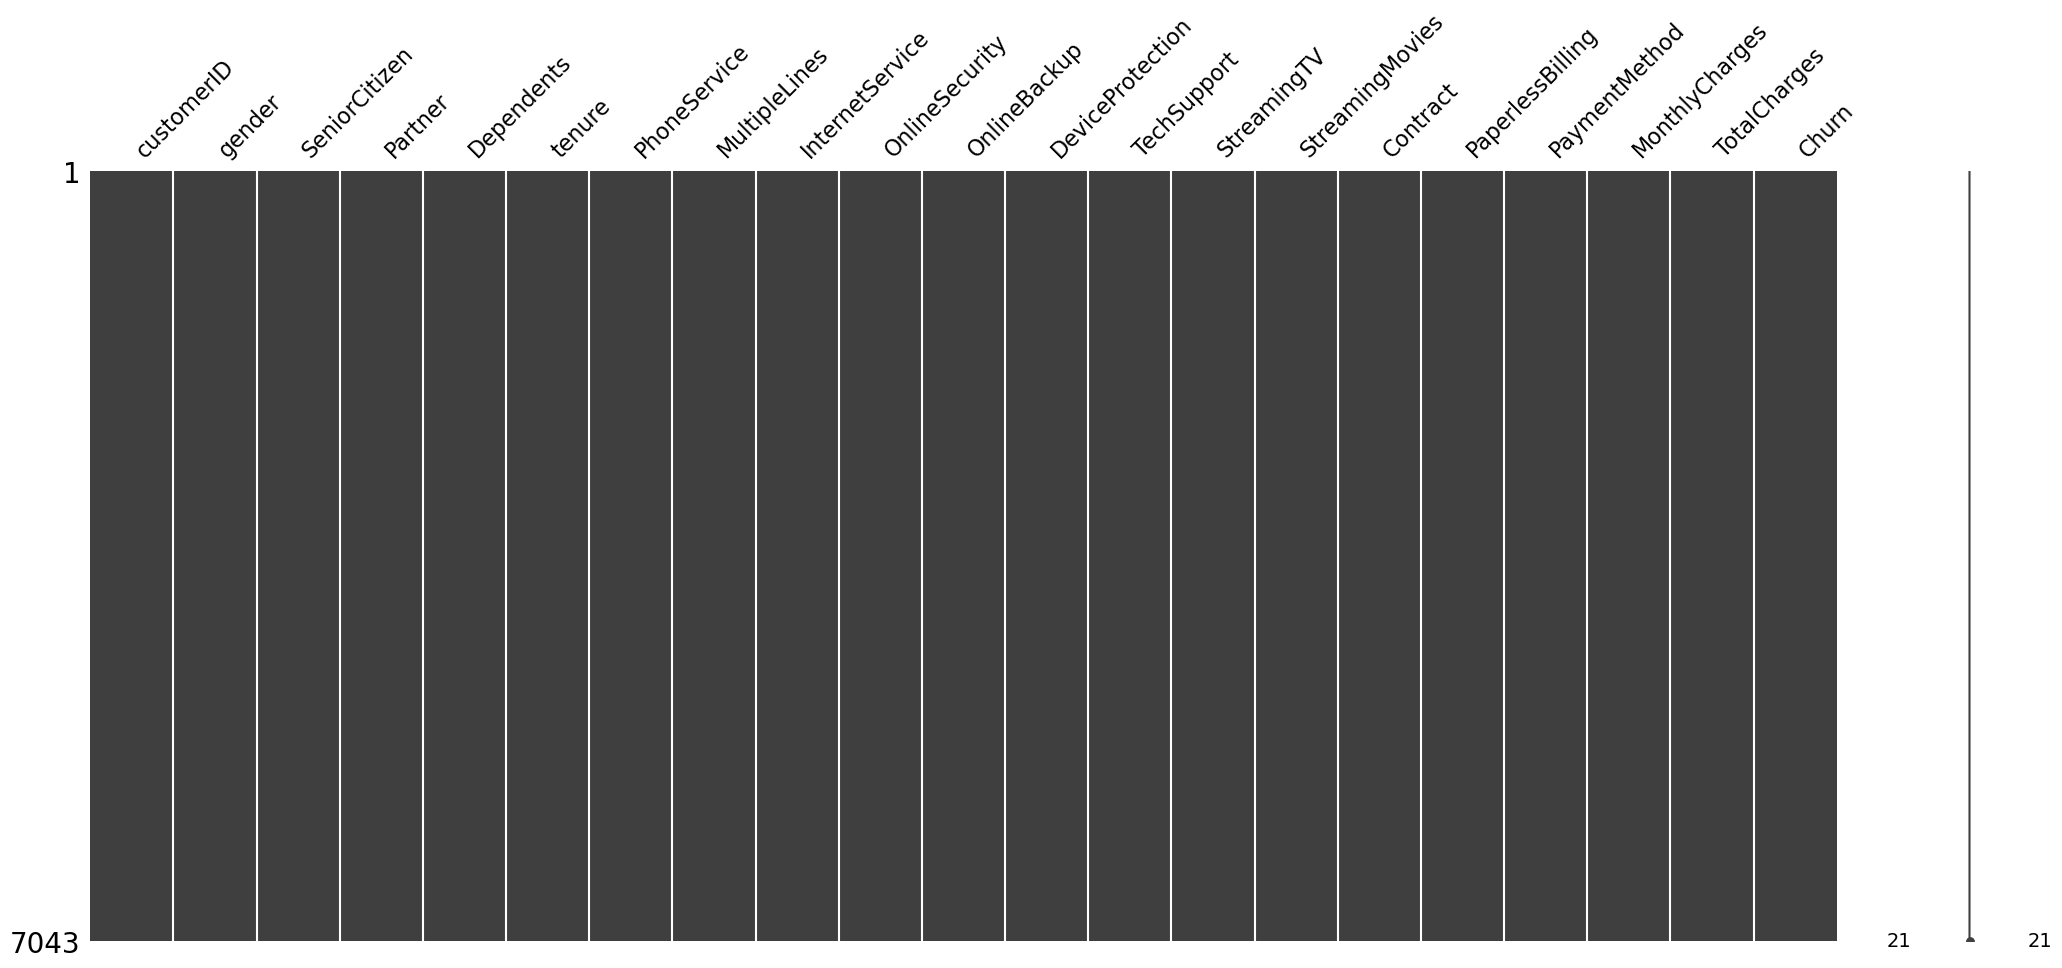

In [ ]:
msno.matrix(data);

In [ ]:
print("Number of customers:",data.shape[0])
print("Number of features used:",data.shape[1])

Number of customers: 7043
Number of features used: 21


In [ ]:
for i in data.columns[6:-3]:
  print(f'Number of categories in the variable {i}: {len(data[i].unique())}')

Number of categories in the variable PhoneService: 2
Number of categories in the variable MultipleLines: 3
Number of categories in the variable InternetService: 3
Number of categories in the variable OnlineSecurity: 3
Number of categories in the variable OnlineBackup: 3
Number of categories in the variable DeviceProtection: 3
Number of categories in the variable TechSupport: 3
Number of categories in the variable StreamingTV: 3
Number of categories in the variable StreamingMovies: 3
Number of categories in the variable Contract: 3
Number of categories in the variable PaperlessBilling: 2
Number of categories in the variable PaymentMethod: 4


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
data.describe()

SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

In [ ]:
data.describe(include=object).T

count unique               top  freq
customerID        7043   7043        7590-VHVEG     1
gender            7043      2              Male  3555
Partner           7043      2                No  3641
Dependents        7043      2                No  4933
PhoneService      7043      2               Yes  6361
MultipleLines     7043      3                No  3390
InternetService   7043      3       Fiber optic  3096
OnlineSecurity    7043      3                No  3498
OnlineBackup      7043      3                No  3088
DeviceProtection  7043      3                No  3095
TechSupport       7043      3                No  3473
StreamingTV       7043      3                No  2810
StreamingMovies   7043      3                No  2785
Contract          7043      3    Month-to-month  3875
PaperlessBilling  7043      2               Yes  4171
PaymentMethod     7043      4  Electronic check  2365
TotalCharges      7043   6541              20.2    11
Churn             7043      2                No  5174

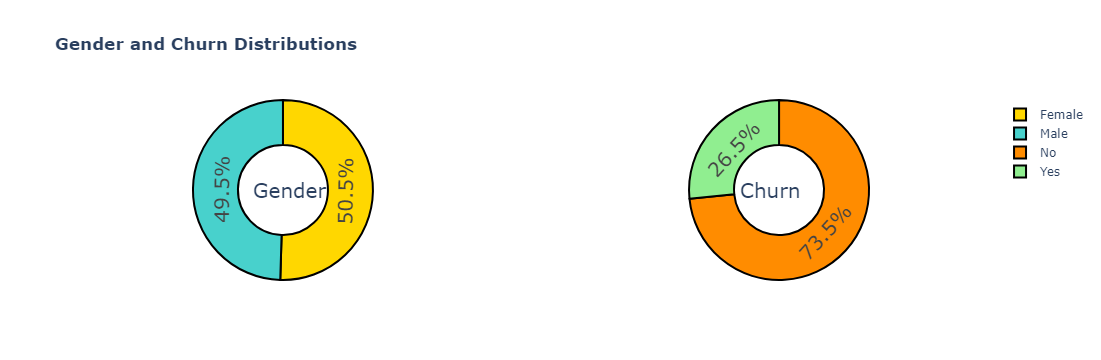

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=data['gender'].unique(), values=data['gender'].value_counts(), name='Gender', 
                     marker_colors=['gold', 'mediumturquoise']), 1, 1)
fig.add_trace(go.Pie(labels=data['Churn'].unique(), values=data['Churn'].value_counts(), name='Churn', 
                     marker_colors=['darkorange', 'lightgreen']), 1, 2)

fig.update_traces(hole=0.5, textfont_size=20, marker=dict(line=dict(color='black', width=2)))

fig.update_layout(
    title_text='<b>Gender and Churn Distributions<b>', 
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Gender', x=0.19, y=0.5, font_size=20, showarrow=False),
                 dict(text='Churn', x=0.8, y=0.5, font_size=20, showarrow=False)])
iplot(fig)


In [ ]:
import pandas as pd
df = pd.read_csv('customer-churn-dataset.csv')

In [ ]:
import pandas as pd
columns_needed = ['Churn', 'gender']
selected_data = df[columns_needed]

In [ ]:
pip install plotly pandas

Note: you may need to restart the kernel to use updated packages.


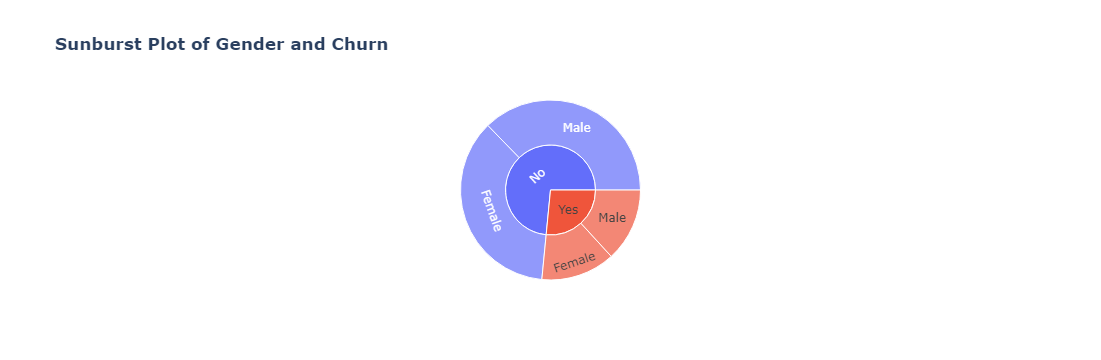

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio
import pandas as pd

fig = px.sunburst(selected_data, path=['Churn', 'gender'], title='<b>Sunburst Plot of Gender and Churn</b>')

fig_widget = go.FigureWidget(fig)

pio.show(fig_widget)

In [ ]:
print(f'A female customer has a probability of {round(data[(data["gender"] == "Female") & (data["Churn"] == "Yes")].count()[0] / data[(data["gender"] == "Female")].count()[0] *100,2)} % churn')

print(f'A male customer has a probability of {round(data[(data["gender"] == "Male") & (data["Churn"] == "Yes")].count()[0] / data[(data["gender"] == "Male")].count()[0]*100,2)} % churn')

A female customer has a probability of 26.92 % churn
A male customer has a probability of 26.16 % churn


In [ ]:
columns_needed = ['Churn', 'Contract']
churn_customer = df[columns_needed]

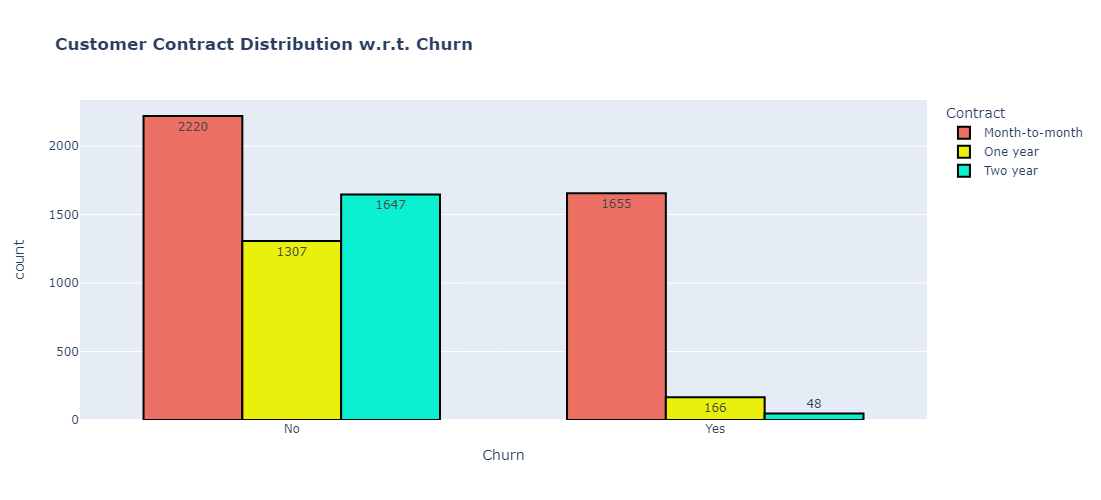

In [ ]:
fig = px.histogram(churn_customer, x='Churn', color='Contract', barmode='group', title='<b>Customer Contract Distribution w.r.t. Churn<b>', 
                   color_discrete_sequence = ['#EC7063','#E9F00B','#0BF0D1'], text_auto=True)

fig.update_layout(width=1100, height=500, bargap=0.3)
fig.update_traces(marker_line_width=2,marker_line_color='black')

iplot(fig)

In [ ]:
print(f'A customer with month-to-month contract has a probability of {round(churn_customer[(churn_customer["Contract"] == "Month-to-month") & (churn_customer["Churn"] == "Yes")].count()[0] / churn_customer[(churn_customer["Contract"] == "Month-to-month")].count()[0] *100,2)} % churn')

print(f'A customer with one year contract has a probability of {round(churn_customer[(churn_customer["Contract"] == "One year") & (churn_customer["Churn"] == "Yes")].count()[0] / churn_customer[(churn_customer["Contract"] == "One year")].count()[0]*100,2)} % churn')

print(f'A customer with two year contract has a probability of {round(churn_customer[(churn_customer["Contract"] == "Two year") & (churn_customer["Churn"] == "Yes")].count()[0] / churn_customer[(churn_customer["Contract"] == "Two year")].count()[0]*100,2)} % churn')

A customer with month-to-month contract has a probability of 42.71 % churn
A customer with one year contract has a probability of 11.27 % churn
A customer with two year contract has a probability of 2.83 % churn


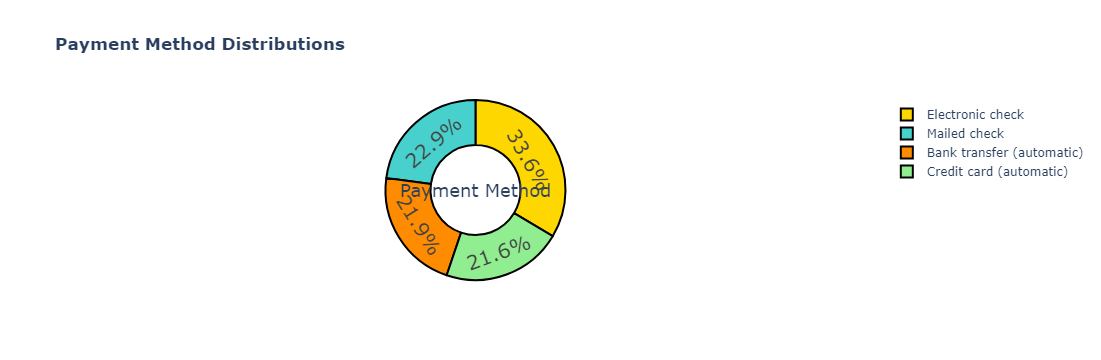

In [ ]:
fig = make_subplots(rows=1, cols=1, specs=[[{'type':'domain'}]])

fig.add_trace(go.Pie(labels=data['PaymentMethod'].unique(), values=data['PaymentMethod'].value_counts(), name='Payment Method',
                     marker_colors=['gold', 'mediumturquoise','darkorange', 'lightgreen']), 1, 1)

fig.update_traces(hole=0.5, textfont_size=20, marker=dict(line=dict(color='black', width=2)))

fig.update_layout(
    title_text='<b>Payment Method Distributions<b>', 
    annotations=[dict(text='Payment Method', x=0.5, y=0.5, font_size=18, showarrow=False)])
iplot(fig)

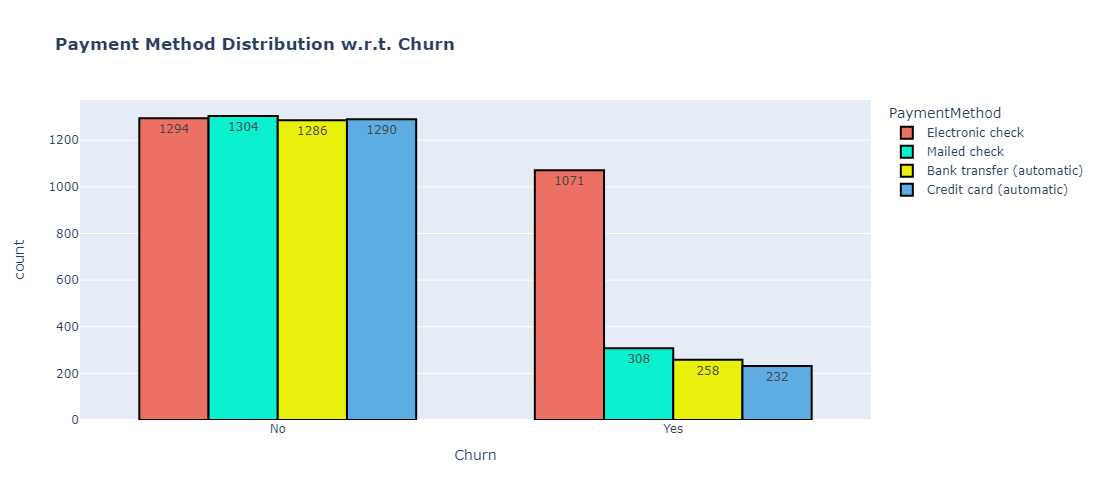

In [ ]:
fig = px.histogram(data, x='Churn', color='PaymentMethod', barmode='group', title='<b>Payment Method Distribution w.r.t. Churn<b>', 
                   color_discrete_sequence = ['#EC7063', '#0BF0D1', '#E9F00B', '#5DADE2'], text_auto=True)

fig.update_layout(width=1100, height=500, bargap=0.3)
fig.update_traces(marker_line_width=2,marker_line_color='black')

iplot(fig)

In [ ]:
print(f'A customer that use Electronic check for paying has a probability of {round(data[(data["PaymentMethod"] == "Electronic check") & (data["Churn"] == "Yes")].count()[0] / data[(data["PaymentMethod"] == "Electronic check")].count()[0] *100,2)} % churn')

print(f'A customer that use Mailed check for paying has a probability of {round(data[(data["PaymentMethod"] == "Mailed check") & (data["Churn"] == "Yes")].count()[0] / data[(data["PaymentMethod"] == "Mailed check")].count()[0]*100,2)} % churn')

print(f'A customer that use Bank transfer (automatic) for paying has a probability of {round(data[(data["PaymentMethod"] == "Bank transfer (automatic)") & (data["Churn"] == "Yes")].count()[0] / data[(data["PaymentMethod"] == "Bank transfer (automatic)")].count()[0]*100,2)} % churn')

print(f'A customer that use Credit card (automatic) for paying has a probability of {round(data[(data["PaymentMethod"] == "Credit card (automatic)") & (data["Churn"] == "Yes")].count()[0] / data[(data["PaymentMethod"] == "Credit card (automatic)")].count()[0]*100,2)} % churn')

A customer that use Electronic check for paying has a probability of 45.29 % churn
A customer that use Mailed check for paying has a probability of 19.11 % churn
A customer that use Bank transfer (automatic) for paying has a probability of 16.71 % churn
A customer that use Credit card (automatic) for paying has a probability of 15.24 % churn


In [ ]:
data[data['gender']=='Male'][['InternetService', 'Churn']].value_counts()

InternetService  Churn
DSL              No       993
Fiber optic      No       910
No               No       722
Fiber optic      Yes      633
DSL              Yes      240
No               Yes       57
Name: count, dtype: int64

In [ ]:
data[data['gender']=='Female'][['InternetService', 'Churn']].value_counts()

InternetService  Churn
DSL              No       969
Fiber optic      No       889
No               No       691
Fiber optic      Yes      664
DSL              Yes      219
No               Yes       56
Name: count, dtype: int64

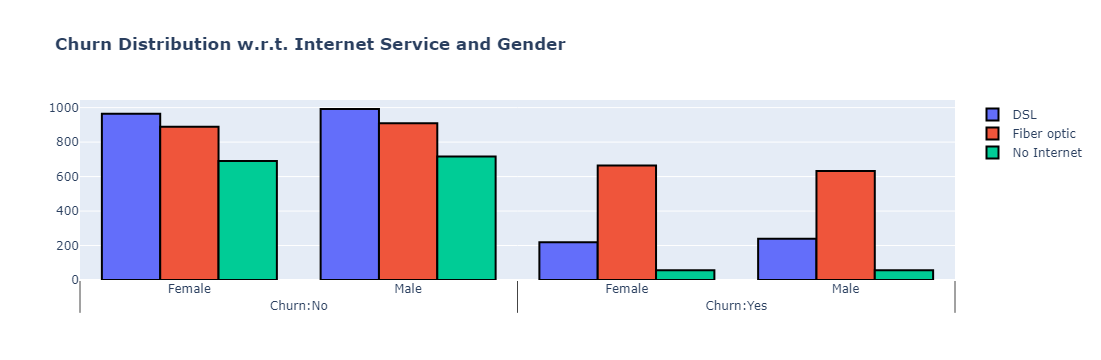

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ['Female', 'Male', 'Female', 'Male']],
  y = [965, 992, 219, 240],
  name = 'DSL', 
))

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ['Female', 'Male', 'Female', 'Male']],
  y = [889, 910, 664, 633],
  name = 'Fiber optic',
))

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ['Female', 'Male', 'Female', 'Male']],
  y = [690, 717, 56, 57],
  name = 'No Internet',
))

fig.update_layout(title_text='<b>Churn Distribution w.r.t. Internet Service and Gender</b>')
fig.update_traces(marker_line_width=2,marker_line_color='black')

iplot(fig)

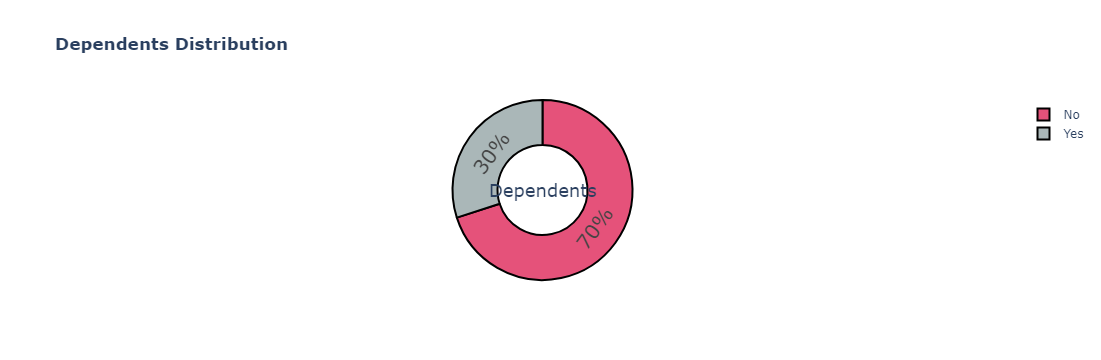

In [ ]:
fig = make_subplots(rows=1, cols=1, specs=[[{'type':'domain'}]])

fig.add_trace(go.Pie(labels=data['Dependents'].unique(), values=data['Dependents'].value_counts(), name='Dependents',
                     marker_colors=['#E5527A ', '#AAB7B8']), 1, 1)

fig.update_traces(hole=0.5, textfont_size=20, marker=dict(line=dict(color='black', width=2)))

fig.update_layout(
    title_text='<b>Dependents Distribution<b>', 
    annotations=[dict(text='Dependents', x=0.5, y=0.5, font_size=18, showarrow=False)])
iplot(fig)

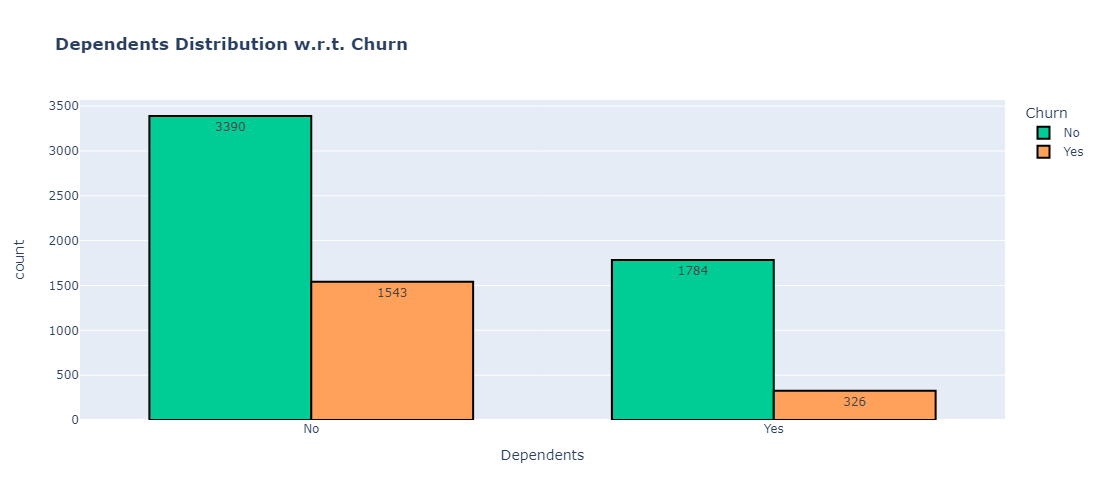

In [ ]:
fig = px.histogram(data, x='Dependents', color='Churn', barmode='group', title='<b>Dependents Distribution w.r.t. Churn<b>', 
                   color_discrete_sequence = ['#00CC96','#FFA15A'], text_auto=True)

fig.update_layout(width=1100, height=500, bargap=0.3)
fig.update_traces(marker_line_width=2,marker_line_color='black')

iplot(fig)

In [ ]:
print(f'A customer with dependents has a probability of {round(data[(data["Dependents"] == "Yes") & (data["Churn"] == "Yes")].count()[0] / data[(data["Dependents"] == "Yes")].count()[0] *100,2)} % churn')

print(f'A customer without dependents has a probability of {round(data[(data["Dependents"] == "No") & (data["Churn"] == "Yes")].count()[0] / data[(data["Dependents"] == "No")].count()[0]*100,2)} % churn')

A customer with dependents has a probability of 15.45 % churn
A customer without dependents has a probability of 31.28 % churn


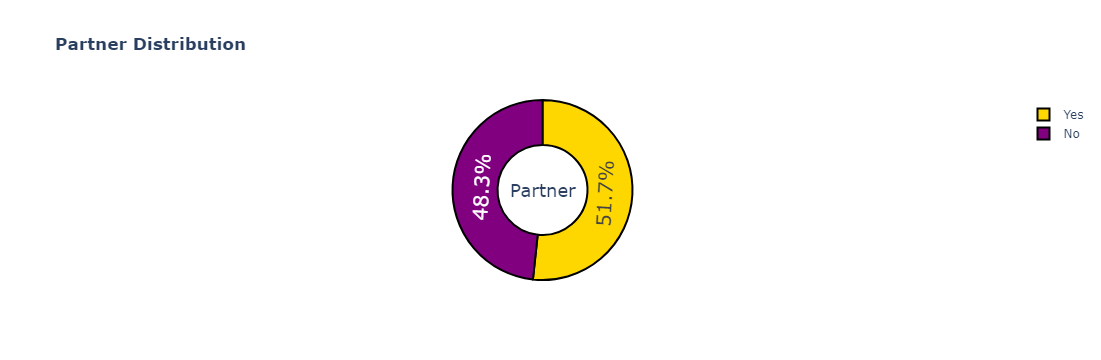

In [ ]:
fig = make_subplots(rows=1, cols=1, specs=[[{'type':'domain'}]])

fig.add_trace(go.Pie(labels=data['Partner'].unique(), values=data['Partner'].value_counts(), name='Partner',
                     marker_colors=['gold', 'purple']), 1, 1)

fig.update_traces(hole=0.5, textfont_size=20, marker=dict(line=dict(color='black', width=2)))

fig.update_layout(
    title_text='<b>Partner Distribution<b>', 
    annotations=[dict(text='Partner', x=0.5, y=0.5, font_size=18, showarrow=False)])
iplot(fig)

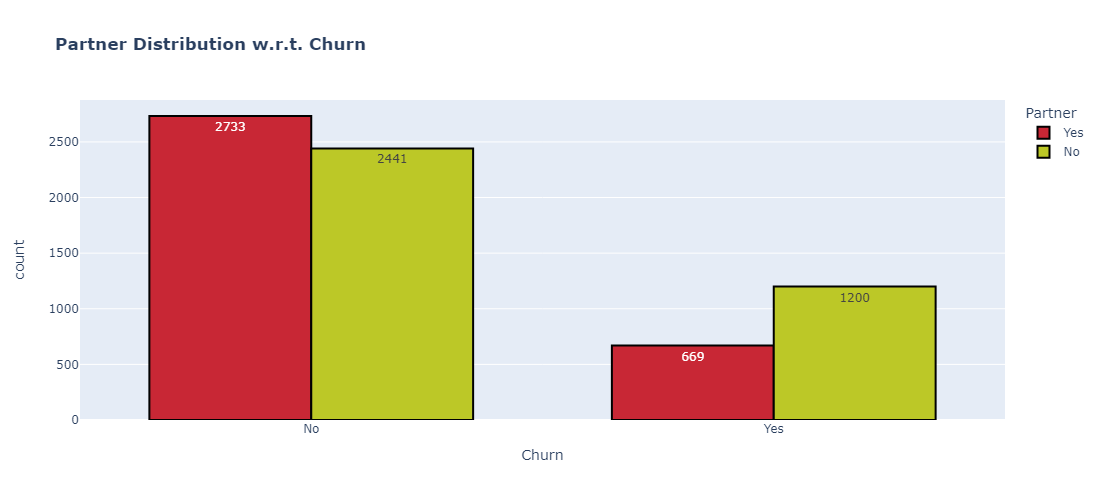

In [ ]:
fig = px.histogram(data, x='Churn', color='Partner', barmode='group', title='<b>Partner Distribution w.r.t. Churn<b>', 
                   color_discrete_sequence = ['#C82735','#BCC827'], text_auto=True)

fig.update_layout(width=1100, height=500, bargap=0.3)
fig.update_traces(marker_line_width=2,marker_line_color='black')

iplot(fig)

In [ ]:
print(f'A customer with a partner has a probability of {round(data[(data["Partner"] == "Yes") & (data["Churn"] == "Yes")].count()[0] / data[(data["Partner"] == "Yes")].count()[0] *100,2)} % churn')

print(f'A customer without a partner has a probability of {round(data[(data["Partner"] == "No") & (data["Churn"] == "Yes")].count()[0] / data[(data["Partner"] == "No")].count()[0]*100,2)} % churn')

A customer with a partner has a probability of 19.66 % churn
A customer without a partner has a probability of 32.96 % churn


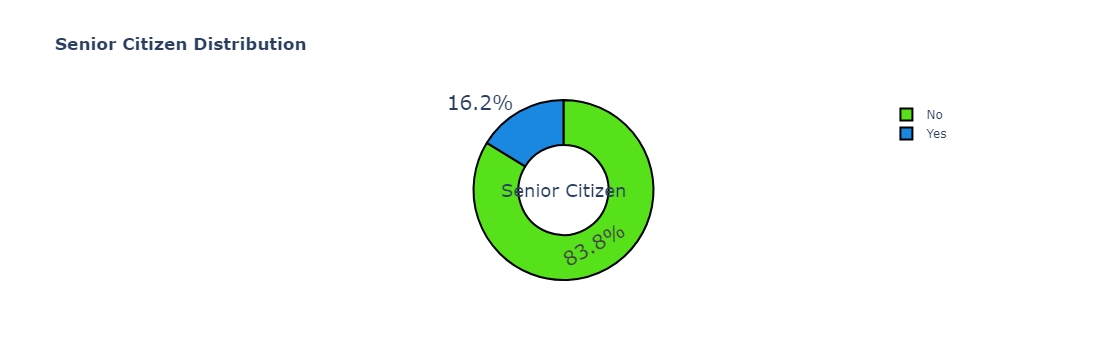

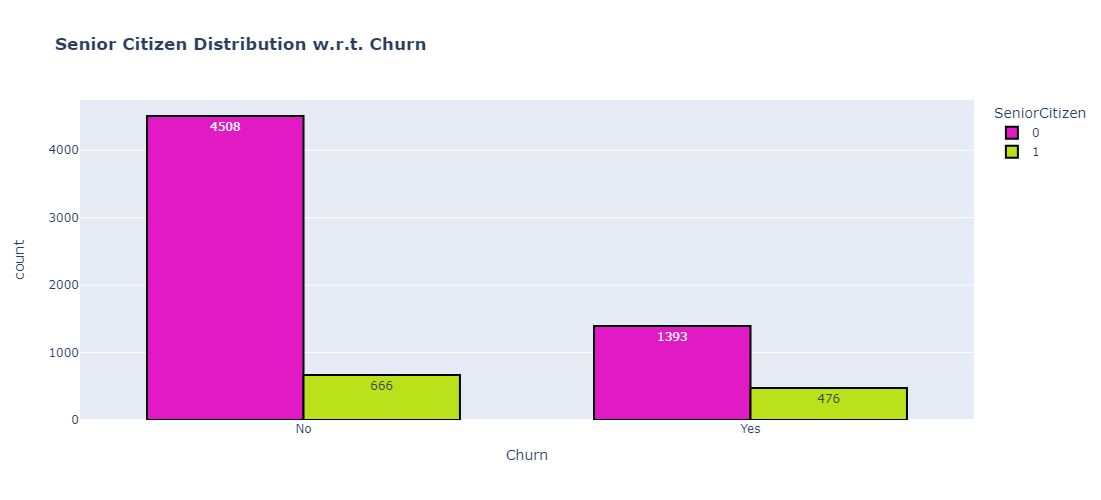

In [ ]:
fig = make_subplots(rows=1, cols=1, specs=[[{'type':'domain'}]])

fig.add_trace(go.Pie(labels=['No', 'Yes'], values=data['SeniorCitizen'].value_counts(), name='Senior Citizen',
                     marker_colors=['#56E11A', '#1A87E1']), 1, 1)

fig.update_traces(hole=0.5, textfont_size=20, marker=dict(line=dict(color='black', width=2)))

fig.update_layout(
    title_text='<b>Senior Citizen Distribution<b>', 
    annotations=[dict(text='Senior Citizen', x=0.5, y=0.5, font_size=18, showarrow=False)])
iplot(fig)
fig = px.histogram(data, x='Churn', color='SeniorCitizen', barmode='group', title='<b>Senior Citizen Distribution w.r.t. Churn<b>', 
                   color_discrete_sequence = ['#E11AC6','#BAE11A'], text_auto=True)

fig.update_layout(width=1100, height=500, bargap=0.3)
fig.update_traces(marker_line_width=2,marker_line_color='black')

iplot(fig)

In [ ]:
print(f'A customer that is a senior citizen has a probability of {round(data[(data["SeniorCitizen"] == 1) & (data["Churn"] == "Yes")].count()[0] / data[(data["SeniorCitizen"] == 1)].count()[0] *100,2)} % churn')

print(f'A customer that is not a senior citizen has a probability of {round(data[(data["SeniorCitizen"] == 0) & (data["Churn"] == "Yes")].count()[0] / data[(data["SeniorCitizen"] == 0)].count()[0]*100,2)} % churn')

A customer that is a senior citizen has a probability of 41.68 % churn
A customer that is not a senior citizen has a probability of 23.61 % churn


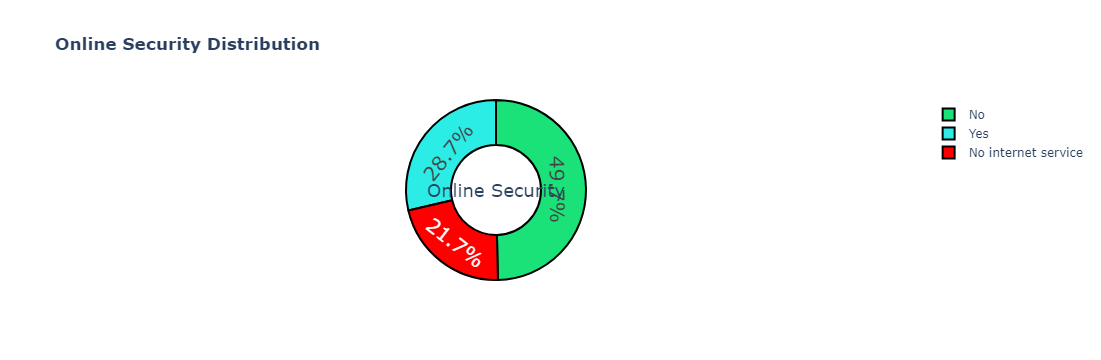

In [ ]:
fig = make_subplots(rows=1, cols=1, specs=[[{'type':'domain'}]])

fig.add_trace(go.Pie(labels=data['OnlineSecurity'].unique(), values=data['OnlineSecurity'].value_counts(), name='OnlineSecurity',
                     marker_colors=['#1AE178', '#2CECE6', 'red']), 1, 1)

fig.update_traces(hole=0.5, textfont_size=20, marker=dict(line=dict(color='black', width=2)))

fig.update_layout(
    title_text='<b>Online Security Distribution<b>', 
    annotations=[dict(text='Online Security', x=0.5, y=0.5, font_size=18, showarrow=False)])
iplot(fig)

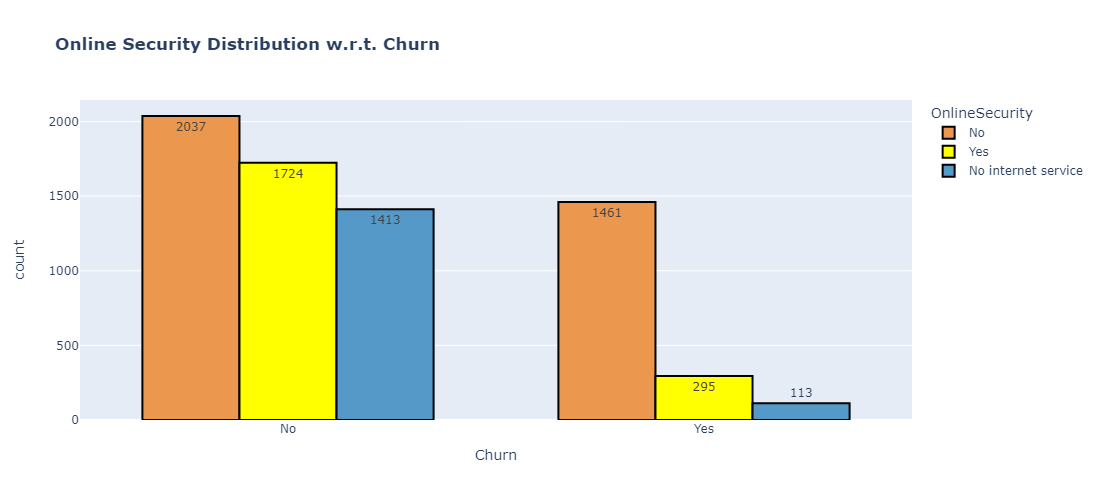

In [ ]:
fig = px.histogram(data, x='Churn', color='OnlineSecurity', barmode='group', title='<b>Online Security Distribution w.r.t. Churn<b>', 
                   color_discrete_sequence = ['#EB984E','yellow', '#5499C7'], text_auto=True)

fig.update_layout(width=1100, height=500, bargap=0.3)
fig.update_traces(marker_line_width=2,marker_line_color='black')

iplot(fig)

In [ ]:
print(f'A customer with an online security has a probability of {round(data[(data["OnlineSecurity"] == "Yes") & (data["Churn"] == "Yes")].count()[0] / data[(data["OnlineSecurity"] == "Yes")].count()[0] *100,2)} % churn')

print(f'A customer without an online security has a probability of {round(data[(data["OnlineSecurity"] == "No") & (data["Churn"] == "Yes")].count()[0] / data[(data["OnlineSecurity"] == "No")].count()[0]*100,2)} % churn')

print(f'A customer with no internet service has a probability of {round(data[(data["OnlineSecurity"] == "No internet service") & (data["Churn"] == "Yes")].count()[0] / data[(data["OnlineSecurity"] == "No internet service")].count()[0]*100,2)} % churn')

A customer with an online security has a probability of 14.61 % churn
A customer without an online security has a probability of 41.77 % churn
A customer with no internet service has a probability of 7.4 % churn


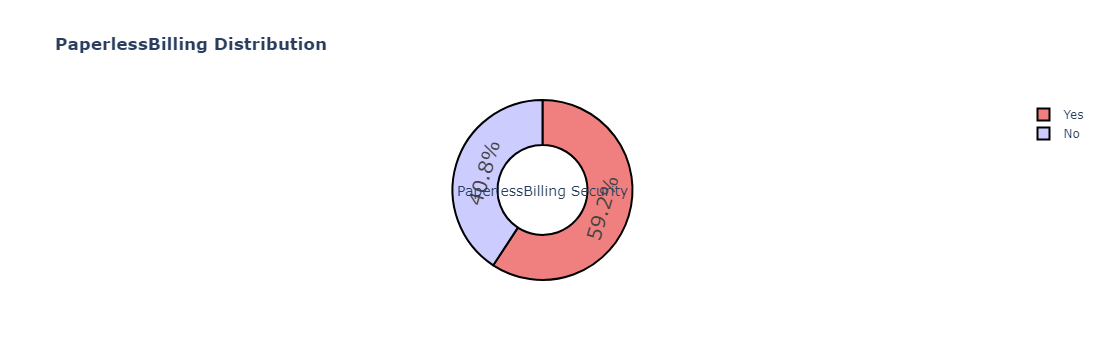

In [ ]:
fig = make_subplots(rows=1, cols=1, specs=[[{'type':'domain'}]])

fig.add_trace(go.Pie(labels=data['PaperlessBilling'].unique(), values=data['PaperlessBilling'].value_counts(), name='PaperlessBilling',
                     marker_colors=['LightCoral', '#CCCCFF']), 1, 1)

fig.update_traces(hole=0.5, textfont_size=20, marker=dict(line=dict(color='black', width=2)))

fig.update_layout(
    title_text='<b>PaperlessBilling Distribution<b>', 
    annotations=[dict(text='PaperlessBilling Security', x=0.5, y=0.5, font_size=14, showarrow=False)])
iplot(fig)


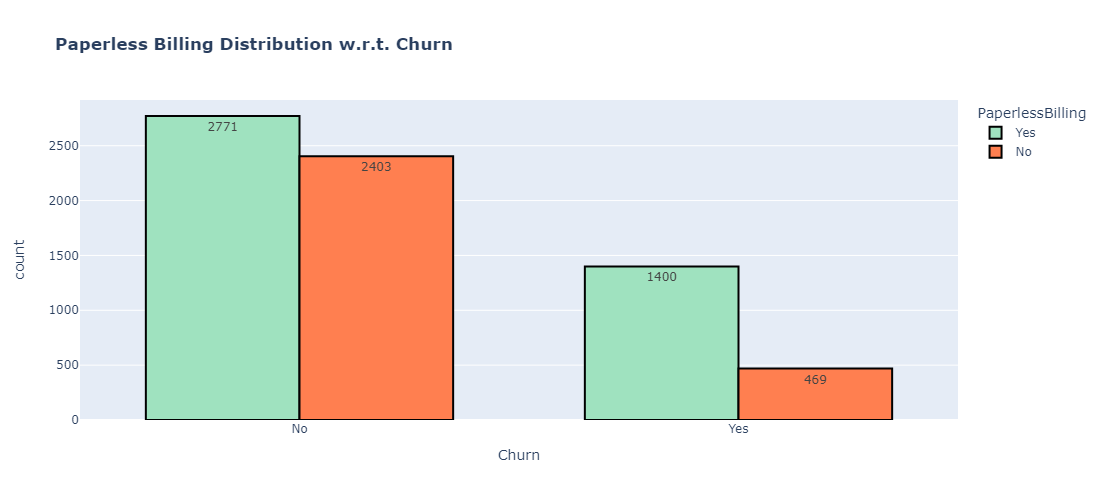

In [ ]:
fig = px.histogram(data, x='Churn', color='PaperlessBilling', barmode='group', title='<b>Paperless Billing Distribution w.r.t. Churn<b>', 
                   color_discrete_sequence = ['#9FE2BF', '#FF7F50'], text_auto=True)

fig.update_layout(width=1100, height=500, bargap=0.3)
fig.update_traces(marker_line_width=2,marker_line_color='black')

iplot(fig)

In [ ]:
print(f'A customer with PaperlessBilling has a probability of {round(data[(data["PaperlessBilling"] == "Yes") & (data["Churn"] == "Yes")].count()[0] / data[(data["PaperlessBilling"] == "Yes")].count()[0] *100,2)} % churn')

print(f'A customer without PaperlessBilling has a probability of {round(data[(data["PaperlessBilling"] == "No") & (data["Churn"] == "Yes")].count()[0] / data[(data["PaperlessBilling"] == "No")].count()[0]*100,2)} % churn')

A customer with PaperlessBilling has a probability of 33.57 % churn
A customer without PaperlessBilling has a probability of 16.33 % churn


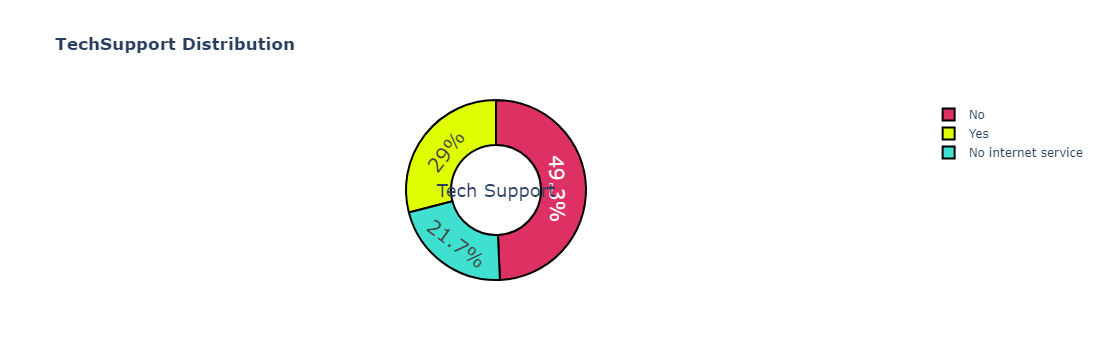

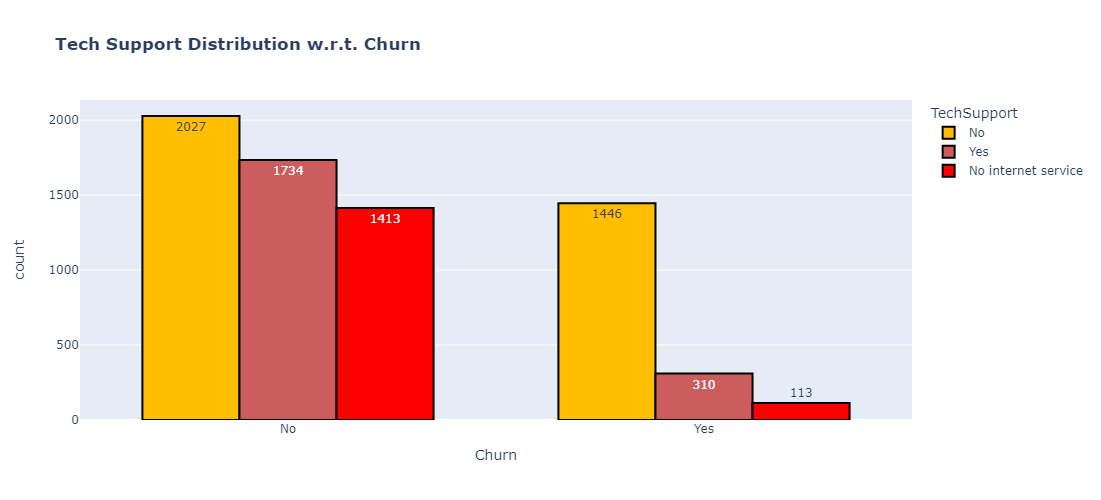

A customer with a tech support has a probability of 15.17 % churn
A customer without a tech support has a probability of 41.64 % churn
A customer with no internet service has a probability of 7.4 % churn


In [ ]:
fig = make_subplots(rows=1, cols=1, specs=[[{'type':'domain'}]])

fig.add_trace(go.Pie(labels=data['TechSupport'].unique(), values=data['TechSupport'].value_counts(), name='TechSupport',
                     marker_colors=['#DE3163', '#DFFF00', '#40E0D0']), 1, 1)

fig.update_traces(hole=0.5, textfont_size=20, marker=dict(line=dict(color='black', width=2)))

fig.update_layout(
    title_text='<b>TechSupport Distribution<b>', 
    annotations=[dict(text='Tech Support', x=0.5, y=0.5, font_size=18, showarrow=False)])
iplot(fig)
fig = px.histogram(data, x='Churn', color='TechSupport', barmode='group', title='<b>Tech Support Distribution w.r.t. Churn<b>', 
                   color_discrete_sequence = ['#FFBF00', 'IndianRed', 'red'], text_auto=True)

fig.update_layout(width=1100, height=500, bargap=0.3)
fig.update_traces(marker_line_width=2,marker_line_color='black')

iplot(fig)
print(f'A customer with a tech support has a probability of {round(data[(data["TechSupport"] == "Yes") & (data["Churn"] == "Yes")].count()[0] / data[(data["TechSupport"] == "Yes")].count()[0] *100,2)} % churn')

print(f'A customer without a tech support has a probability of {round(data[(data["TechSupport"] == "No") & (data["Churn"] == "Yes")].count()[0] / data[(data["TechSupport"] == "No")].count()[0]*100,2)} % churn')

print(f'A customer with no internet service has a probability of {round(data[(data["TechSupport"] == "No internet service") & (data["Churn"] == "Yes")].count()[0] / data[(data["TechSupport"] == "No internet service")].count()[0]*100,2)} % churn')

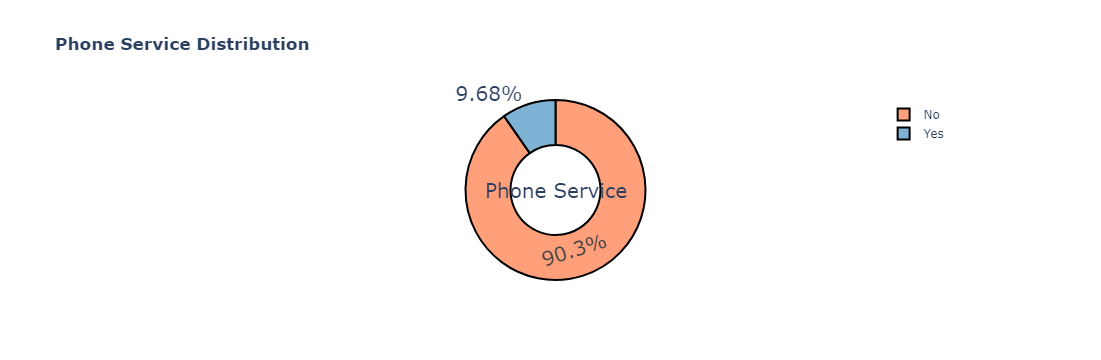

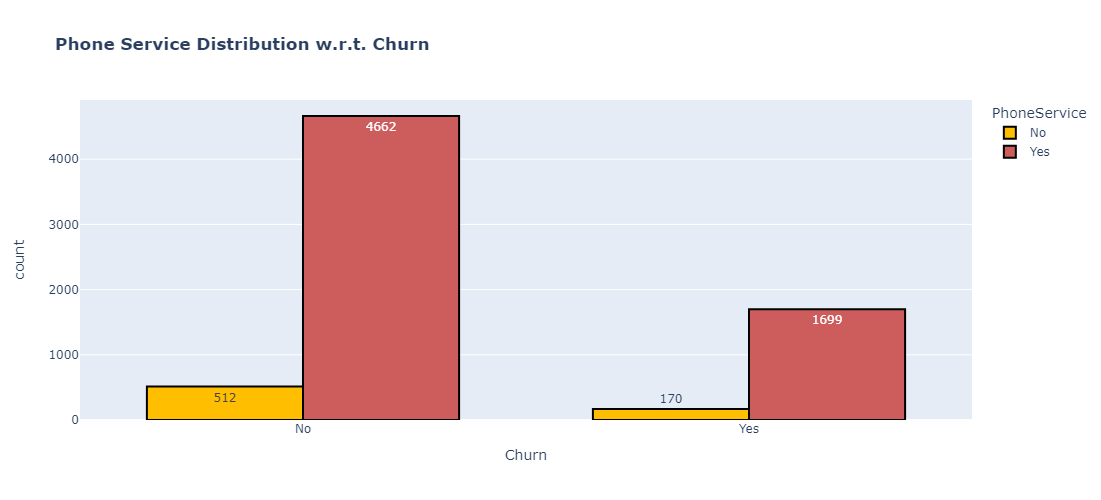

A customer with phone service has a probability of 26.71 % churn
A customer without phone service has a probability of 24.93 % churn


In [ ]:
fig = make_subplots(rows=1, cols=1, specs=[[{'type':'domain'}]])

fig.add_trace(go.Pie(labels=data['PhoneService'].unique(), values=data['PhoneService'].value_counts(), name='PhoneService',
                     marker_colors=['LightSalmon', '#7FB3D5']), 1, 1)

fig.update_traces(hole=0.5, textfont_size=20, marker=dict(line=dict(color='black', width=2)))

fig.update_layout(
    title_text='<b>Phone Service Distribution<b>', 
    annotations=[dict(text='Phone Service', x=0.5, y=0.5, font_size=20, showarrow=False)])
iplot(fig)
fig = px.histogram(data, x='Churn', color='PhoneService', barmode='group', title='<b>Phone Service Distribution w.r.t. Churn<b>', 
                   color_discrete_sequence = ['#FFBF00', 'IndianRed'], text_auto=True)

fig.update_layout(width=1100, height=500, bargap=0.3)
fig.update_traces(marker_line_width=2,marker_line_color='black')

iplot(fig)
print(f'A customer with phone service has a probability of {round(data[(data["PhoneService"] == "Yes") & (data["Churn"] == "Yes")].count()[0] / data[(data["PhoneService"] == "Yes")].count()[0] *100,2)} % churn')

print(f'A customer without phone service has a probability of {round(data[(data["PhoneService"] == "No") & (data["Churn"] == "Yes")].count()[0] / data[(data["PhoneService"] == "No")].count()[0]*100,2)} % churn')

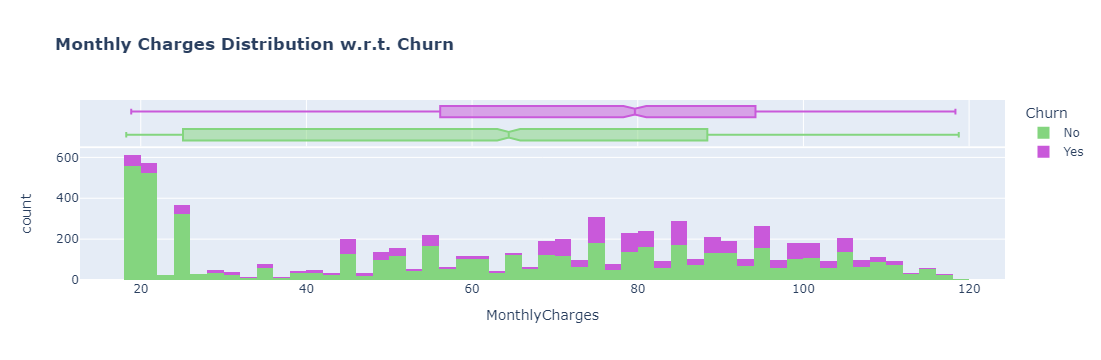

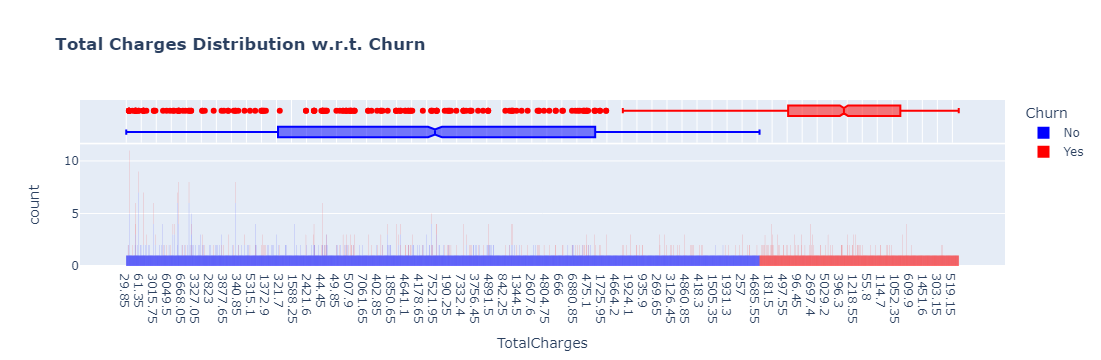

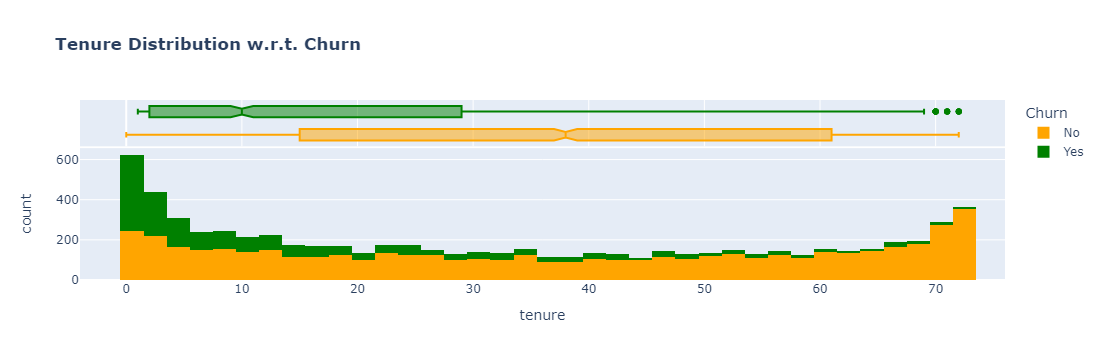

In [ ]:
fig = px.histogram(data, x='MonthlyCharges', color='Churn', marginal='box', title='<b>Monthly Charges Distribution w.r.t. Churn<b>',
             color_discrete_sequence = ['#84D57F', '#C959DA'])
iplot(fig)

fig = px.histogram(data, x='TotalCharges', color='Churn', marginal='box', title='<b>Total Charges Distribution w.r.t. Churn<b>',
             color_discrete_sequence = ['blue', 'red'])
iplot(fig)

fig = px.histogram(data, x='tenure', color='Churn', marginal='box', title='<b>Tenure Distribution w.r.t. Churn<b>',
             color_discrete_sequence = ['orange', 'green'])
iplot(fig)

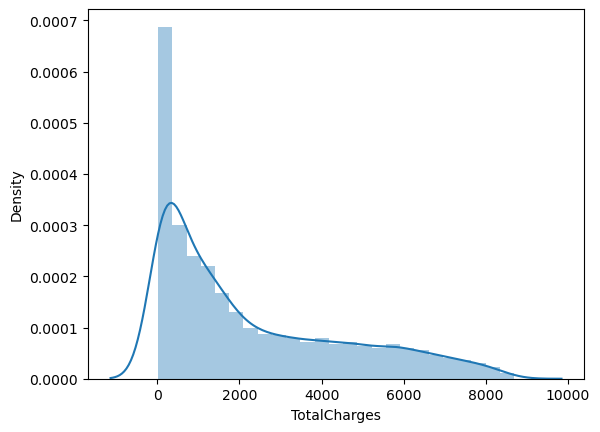

In [ ]:
data=data.drop(labels=['customerID'],axis=1)
sns.distplot(data.TotalCharges);

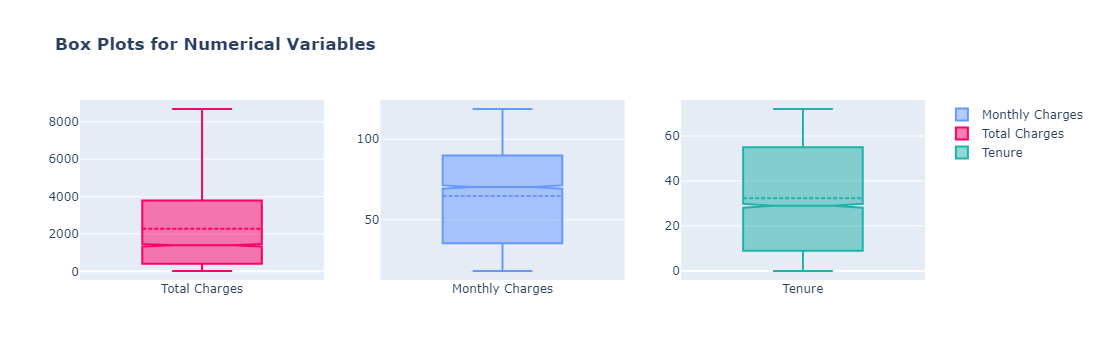

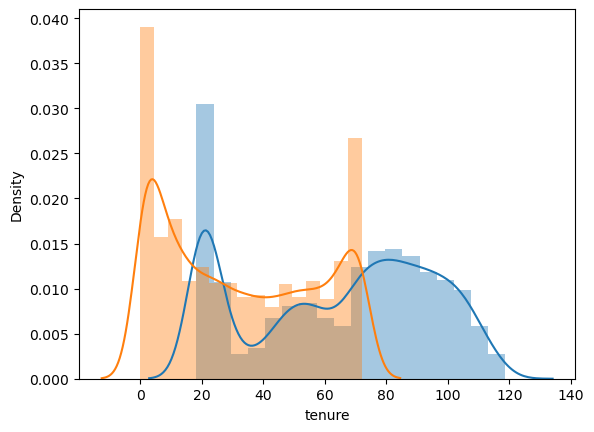

In [ ]:
sns.distplot(data.MonthlyCharges);

sns.distplot(data.tenure);
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y=data['MonthlyCharges'], notched=True, name='Monthly Charges', marker_color = '#6699ff', 
                     boxmean=True, boxpoints='suspectedoutliers'), 1, 2)

fig.add_trace(go.Box(y=data['TotalCharges'], notched=True, name='Total Charges', marker_color = '#ff0066', 
                     boxmean=True, boxpoints='suspectedoutliers'), 1, 1)

fig.add_trace(go.Box(y=data['tenure'], notched=True, name='Tenure', marker_color = 'lightseagreen', 
                     boxmean=True, boxpoints='suspectedoutliers'), 1, 3)

fig.update_layout(title_text='<b>Box Plots for Numerical Variables<b>')

iplot(fig)


In [ ]:
def detect_outliers(d):
  for i in d:
    Q3, Q1 = np.percentile(data[i], [75 ,25])
    IQR = Q3 - Q1

    ul = Q3+1.5*IQR
    ll = Q1-1.5*IQR

    outliers = data[i][(data[i] > ul) | (data[i] < ll)]
    print(f'*** {i} outlier points***', '\n', outliers, '\n')
detect_outliers(['tenure', 'MonthlyCharges', 'TotalCharges'])

*** tenure outlier points*** 
 Series([], Name: tenure, dtype: int64) 

*** MonthlyCharges outlier points*** 
 Series([], Name: MonthlyCharges, dtype: float64) 

*** TotalCharges outlier points*** 
 Series([], Name: TotalCharges, dtype: float64) 



In [ ]:
# check the number of different labels

categorical = [var for var in data.columns if data[var].dtype=='O']
for var in categorical:
    print(data[var].value_counts() / float(len(data)))
    print()
    print()

gender
Male      0.504756
Female    0.495244
Name: count, dtype: float64


Partner
No     0.516967
Yes    0.483033
Name: count, dtype: float64


Dependents
No     0.700412
Yes    0.299588
Name: count, dtype: float64


PhoneService
Yes    0.903166
No     0.096834
Name: count, dtype: float64


MultipleLines
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: count, dtype: float64


InternetService
Fiber optic    0.439585
DSL            0.343746
No             0.216669
Name: count, dtype: float64


OnlineSecurity
No                     0.496663
Yes                    0.286668
No internet service    0.216669
Name: count, dtype: float64


OnlineBackup
No                     0.438450
Yes                    0.344881
No internet service    0.216669
Name: count, dtype: float64


DeviceProtection
No                     0.439443
Yes                    0.343888
No internet service    0.216669
Name: count, dtype: float64


TechSupport
No                     

In [ ]:
data['Churn'] = data['Churn'].map({'Yes':1,'No':0})
data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

In [ ]:
categorical = [var for var in data.columns if data[var].dtype=='O']
def category(df):
    for var in categorical:
        ordered_labels = df.groupby([var])['Churn'].mean().sort_values().index

        ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 
        ordinal_label
        df[var] = df[var].map(ordinal_label)

category(data)
data.dtypes

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

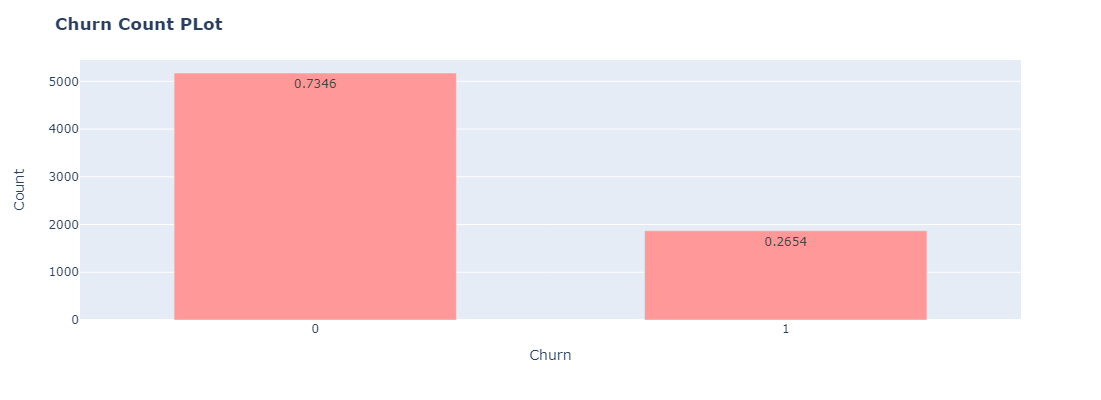

In [ ]:
fig = px.bar(x=data['Churn'].unique()[::-1], y=[data[data['Churn']==1].count()[0], data[data['Churn']==0].count()[0]],
       text=[np.round(data[data['Churn']==1].count()[0]/data.shape[0], 4), np.round(data[data['Churn']==0].count()[0]/data.shape[0], 4)]
       , color_discrete_sequence =['#ff9999'])

fig.update_layout(title_text='<b>Churn Count PLot<b>', xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1),
                  width=700, height=400, bargap=0.4)

fig.update_layout({'yaxis': {'title':'Count'}, 'xaxis': {'title':'Churn'}})

iplot(fig)